# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

In [3]:
df = stats.get_df()
df.head()

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,"Cardiac, facial, and digital anomalies with de...",OMIM:618164,37,TRAF7,NM_032271.3:c.1964G>A,,PMID:32376980
1,"Cardiac, facial, and digital anomalies with de...",OMIM:618164,43,TRAF7,NM_032271.3:c.1964G>A,,PMID:32376980
2,"Cardiac, facial, and digital anomalies with de...",OMIM:618164,"6 (= patient DDD4K.01539 in DDD study, Nature,...",TRAF7,NM_032271.3:c.1204C>G,,PMID:32376980
3,"Cardiac, facial, and digital anomalies with de...",OMIM:618164,25,TRAF7,NM_032271.3:c.1851C>G,,PMID:32376980
4,"Cardiac, facial, and digital anomalies with de...",OMIM:618164,30,TRAF7,NM_032271.3:c.1885A>C,,PMID:32376980


In [4]:
stats_d = stats.get_descriptive_stats()
for k,v in stats_d.items():
    print(k,v)

phenopackets 4188
diseases 388
genes 347
alleles 2089
PMIDs 615
individuals per disease (max) 464
individuals per disease (min) 1
individuals per disease (mean) 10.793814432989691
individuals per disease (median) 1.0
individuals per disease (n>=10) 88
individuals per disease (n>=20) 45
individuals per disease (n>=50) 17
individuals per disease (n>=100) 6
genes associated with a single disease 326
genes associated with two diseases 13
genes associated with multiple diseases 21
gene with maximum number of diseases SCO2 with 7 associated diseases
individuals per gene (max) 464
individuals per gene (min) 1
individuals per gene (mean) 12.069164265129682
individuals per gene (median) 1.0
individuals per gene (n>=10) 68
individuals per gene (n>=20) 42
individuals per gene (n>=50) 19
individuals per gene (n>=100) 8


In [5]:
counts_per_disease = stats.get_counts_per_disease()
counts_per_disease.head()

disease_id
OMIM:612164    464
OMIM:613721    343
OMIM:148050    328
OMIM:613826    191
OMIM:615471    125
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_max(
        disease_counts: pd.Series, 
        max_val: int, 
        ax=None,
        ):
    assert isinstance(max_val, int) and max_val > 0, '`max_val` must be a positive `int`'

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4), dpi=100)

    bins = list(range(max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f'≥{max_val}']
    cats = pd.cut(
        x=disease_counts, 
        bins=bins, 
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel='Number of cases',
        ylabel='Disease count',
    )
    ax.grid(axis='y')


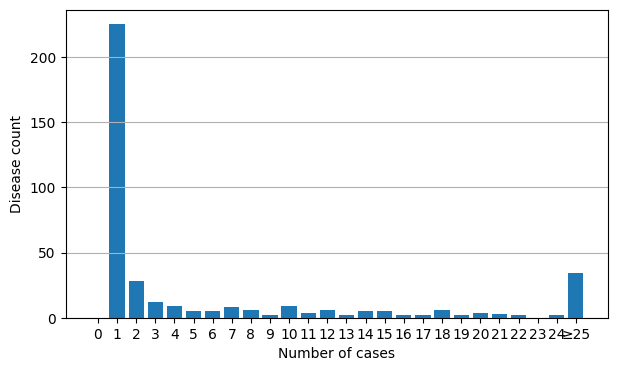

In [7]:
plot_with_max(
    disease_counts=counts_per_disease, 
    max_val=25,
)

EOF